In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import PIL.Image

import tensorflow as tf
#tf.config.set_visible_devices([], 'GPU')

import scipy
import sklearn

# Reference
# https://www.tensorflow.org/tutorials/generative/style_transfer
# https://arxiv.org/abs/1508.06576

In [2]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [3]:

def extract_intermediate_layers(model, layer_names):
    model = model(include_top=False, weights='imagenet')
    outputs = [
        model.get_layer(name).output for name in layer_names
    ]
    return tf.keras.Model(inputs=model.input, outputs=outputs)

def compute_gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


class StyleContentExtractor(tf.keras.Model):
    
    
    def __init__(self, model, content_layers, style_layers, **kwargs):
        
        super(StyleContentExtractor, self).__init__(**kwargs) 
        
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(self.style_layers)
        
        self.model = extract_intermediate_layers(
            model,
            self.style_layers + self.content_layers)
        
        self.model.trainable=False
    
    def call(self, inputs):
        
        inputs = inputs * 255.0
        inputs  = tf.keras.applications.resnet.preprocess_input(
            inputs)
        
        outputs = self.model(inputs)
        content_outputs = outputs[self.num_style_layers:]
        style_outputs = [
            compute_gram_matrix(style_output) 
            for style_output in outputs[:self.num_style_layers]
        ]
        
        content_dict = {
            name:value for name, value in zip(self.content_layers, content_outputs)
        }
        style_dict = {
            name:value for name, value in zip(self.style_layers, style_outputs)
        }
        
        return {'content': content_dict, 'style': style_dict}
     

In [13]:

class NeuralStyleTransfer:
    
    def __init__(self, 
                 model,
                 optimizer,
                 content_layers, 
                 style_layers, 
                 content_loss_weight=10_000, 
                 style_loss_weight=0.01,
                 total_variation_loss_weight=30):
        
        self.optimizer = optimizer
        self.extractor = StyleContentExtractor(
            model,
            content_layers=content_layers, style_layers=style_layers
        )
        self.num_content_layers = len(content_layers)
        self.num_style_layers = len(style_layers)
        self.content_loss_weight = content_loss_weight
        self.style_loss_weight = style_loss_weight
        self.total_variation_loss_weight = total_variation_loss_weight
    
    def _compute_loss(self, targets, outputs):
        style_outputs = outputs['style']
        style_targets = targets['style']
        content_outputs = outputs['content']
        content_targets = targets['content']
        
        content_loss = tf.add_n(
            [tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
            for name in content_outputs.keys()]
        )
        content_loss *= self.content_loss_weight / self.num_content_layers
        
        style_loss = tf.add_n(
            [tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
             for name in style_outputs.keys()]
        )
        style_loss *= self.style_loss_weight / self.num_style_layers
            
        return content_loss + style_loss
        
    def _backprop_loss(self, tape, loss, weights):
        gradients = tape.gradient(loss, weights)
        self.optimizer.apply_gradients([(gradients, weights)])
        weights.assign(tf.clip_by_value(weights, 0.0, 1.0))
    
    def _get_train_step(self):
        @tf.function
        def _train_step(image, targets):
            with tf.GradientTape() as tape:
                outputs = self.extractor(image)
                loss = self._compute_loss(targets, outputs)
                loss += (
                    self.total_variation_loss_weight 
                    * tf.image.total_variation(image)
                )
            self._backprop_loss(tape, loss, image)
            return loss
        return _train_step
        
    def fit_style(self, image, targets, iterations):
        
        self.image = image
        
        train_step = self._get_train_step()
        
        pbar = tqdm.tqdm(range(iterations))
        for i in pbar:
            loss = train_step(self.image, targets)
            pbar.set_description('Loss = {}'.format(loss))
            
    @property
    def get_styled_image(self):
        return self.image
    

model = NeuralStyleTransfer(
    model=tf.keras.applications.VGG19,
    optimizer=tf.optimizers.Adam(learning_rate=1e-1),
    content_layers=['block5_conv2'] ,
    style_layers=['block1_conv1',
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1', 
                  'block5_conv1'], 
    content_loss_weight=10_000, 
    style_loss_weight=0.01,
    total_variation_loss_weight=30)

In [15]:
def load_img(path_to_img, target_size=512):
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = target_size / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    return img[tf.newaxis]

content_image = load_img('pranee2.jpg')
style_image   = load_img(style_path)

targets = {'content': model.extractor(content_image)['content'],
           'style': model.extractor(style_image)['style']
          }

for name, output in sorted(targets['content'].items()):
    print(name, output.shape)
    
for name, output in sorted(targets['style'].items()):
    print(name, output.shape)


image = tf.Variable(content_image)

model.fit_style(image, targets, iterations=5000)

block5_conv2 (1, 32, 24, 512)
block1_conv1 (1, 64, 64)
block2_conv1 (1, 128, 128)
block3_conv1 (1, 256, 256)
block4_conv1 (1, 512, 512)
block5_conv1 (1, 512, 512)


KeyboardInterrupt: 

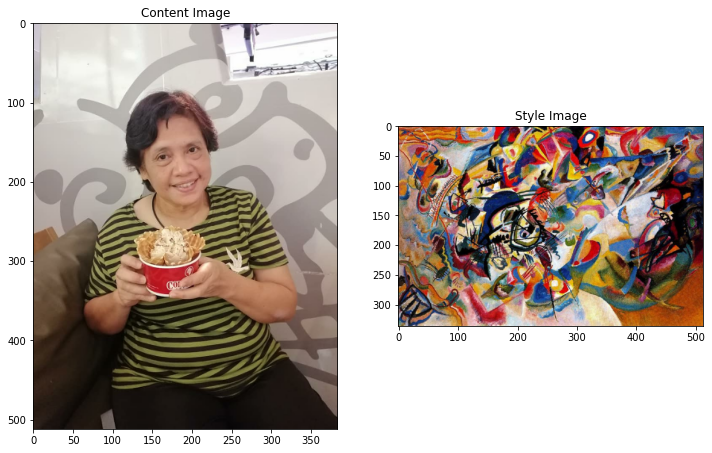

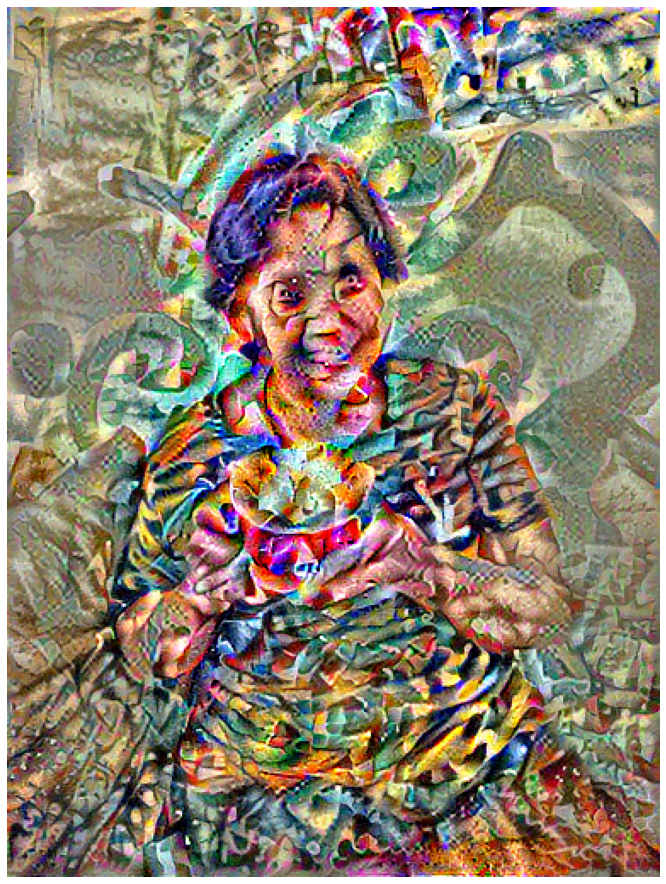

In [16]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
        
        
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

plt.figure(figsize=(16, 16))
plt.imshow(np.squeeze(model.get_styled_image.numpy()))
plt.axis('off');